In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import numpy as np
import os, shutil
import pandas, csv, json
import random
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({u'font.sans-serif':['simhei']})
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import scipy
import math
from scipy.stats import genextreme as gev, gumbel_r, norm, gompertz
from scipy.special import gamma, factorial

from constants import * 
from utils import *

In [3]:
def get_scope(x, y):
    x_list, y_list = [], []
    index = np.where(y==1)[0]
    if len(index) == 0:
        return x_list, y_list
    st = index[0]
    ed = index[0]
    for i in range(1, len(index)):
        obj = index[i]
        if obj == ed + 1:
            ed = obj
        else:
            x_list.append(x[st:ed+1])
            y_list.append(y[st:ed+1])
            st, ed = obj, obj
    x_list.append(x[st:ed+1])
    y_list.append(y[st:ed+1])
    return x_list, y_list

In [19]:
def get_mask(opt, data, thres):
    mask = np.zeros((data.shape[0]))
    if opt.is_min_threshold:
        index = np.argwhere(thres>=opt.threshold)
        thres[index] = opt.threshold
    dif_data = abs(data[1:] - data[:-1]) if opt.use_abs_delta else data[1:] - data[:-1]
    index = np.argwhere(dif_data>=10)[:, 0] + 1
    mask[index] = 1
    mask[data>=thres] = 1
    return mask

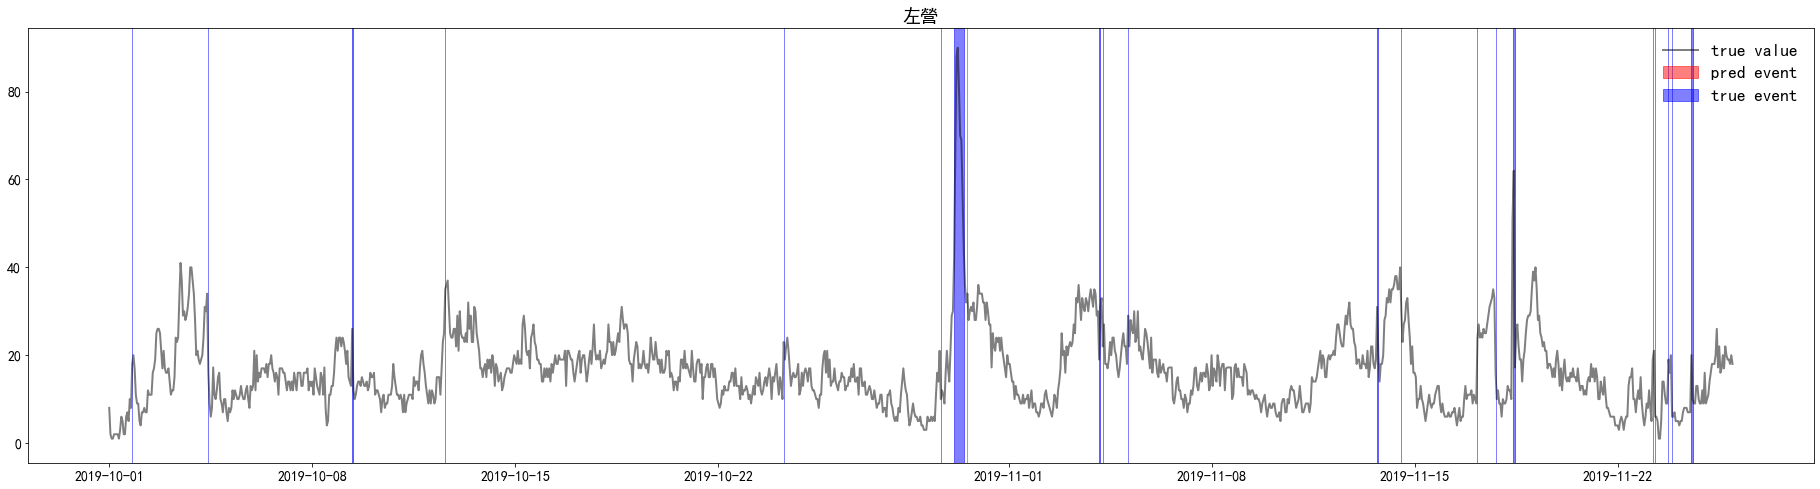

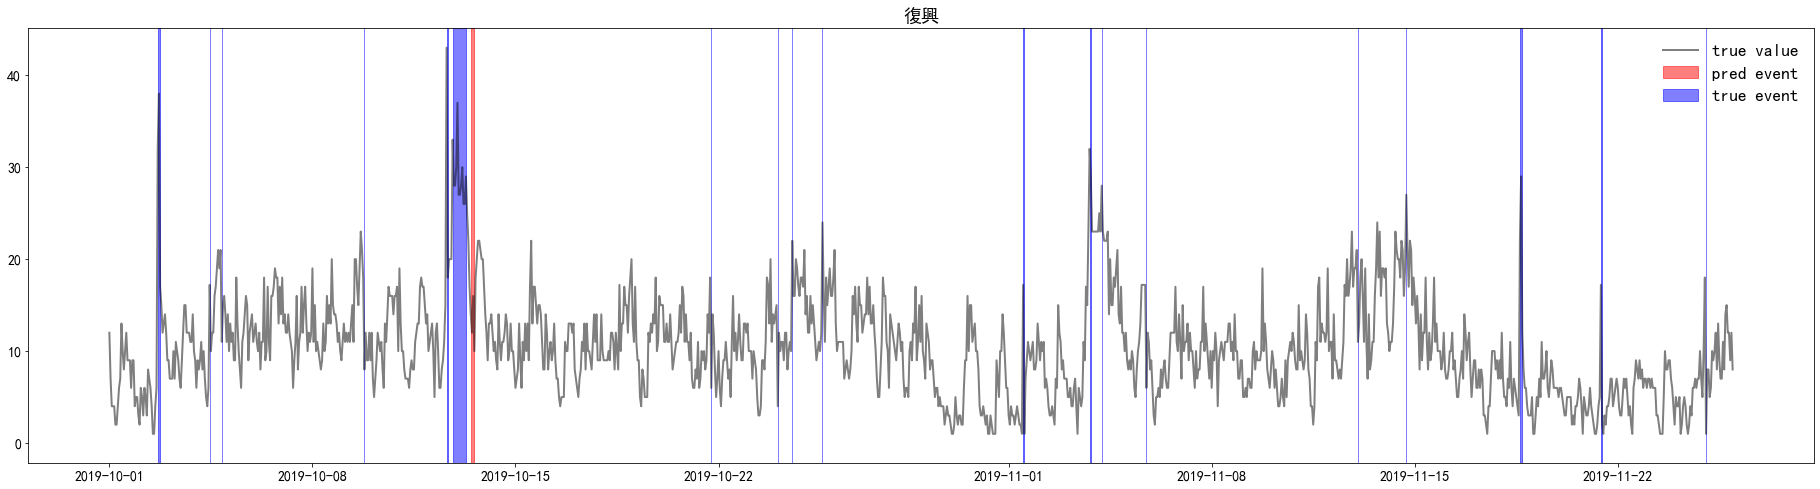

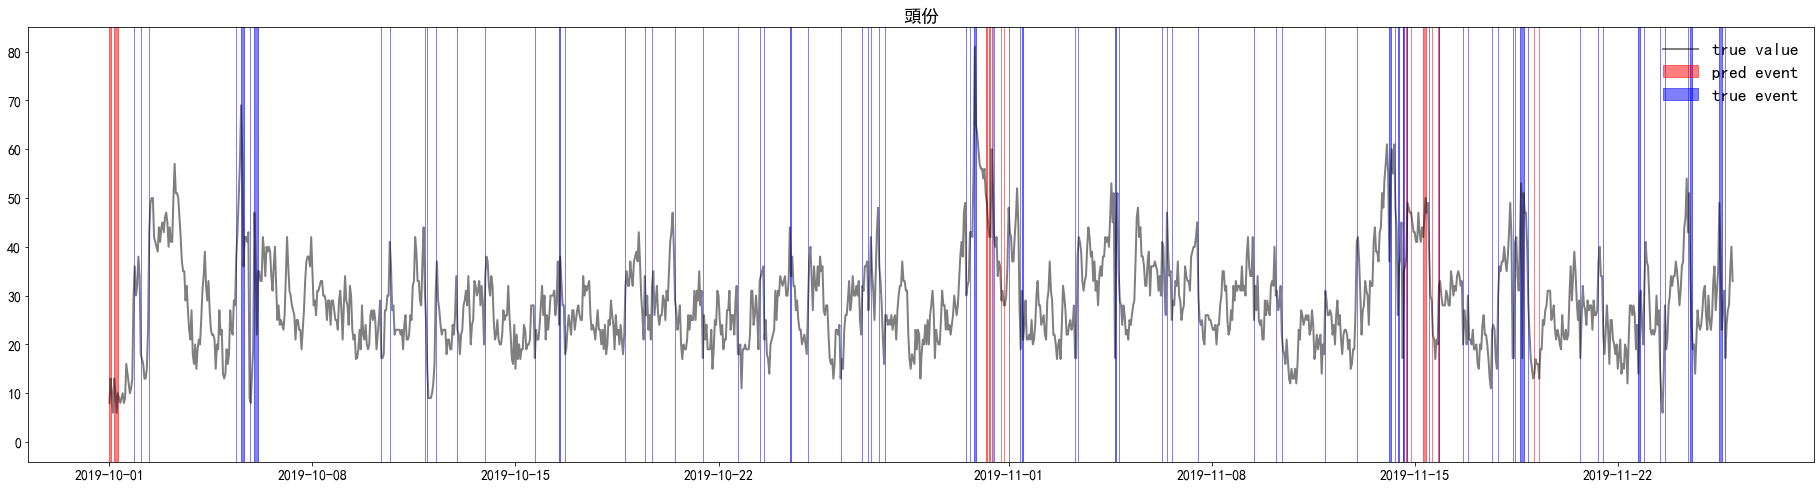

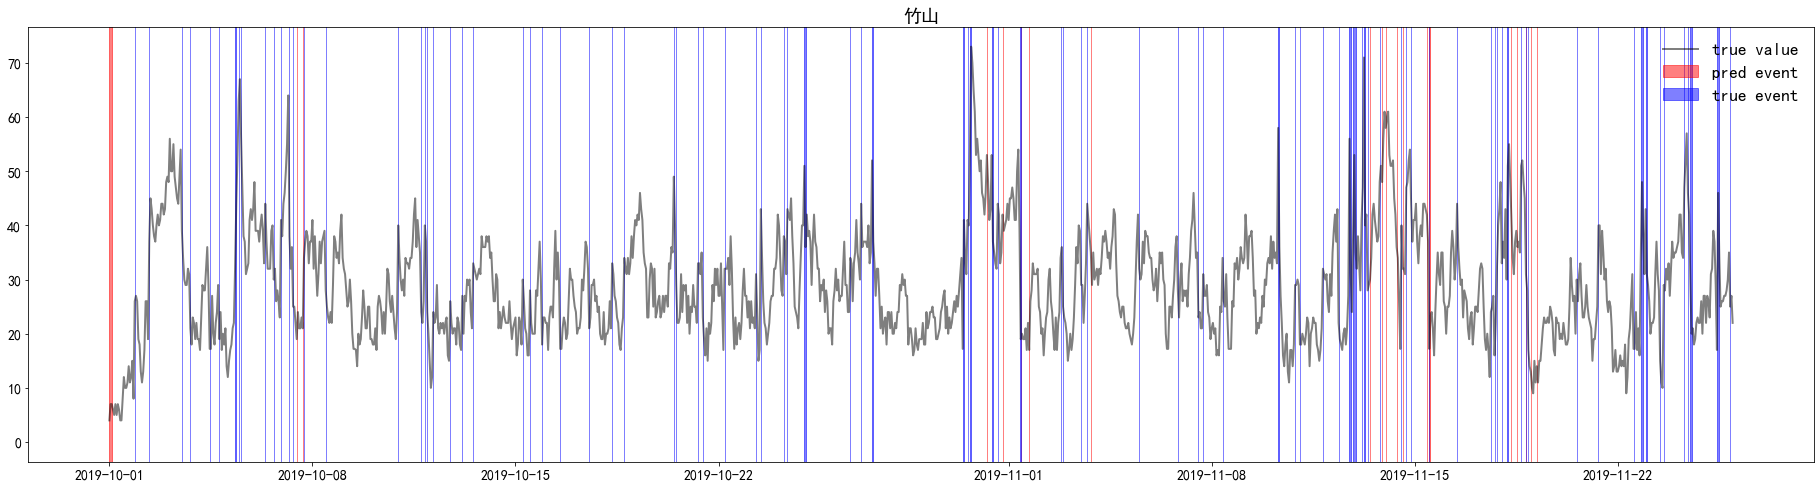

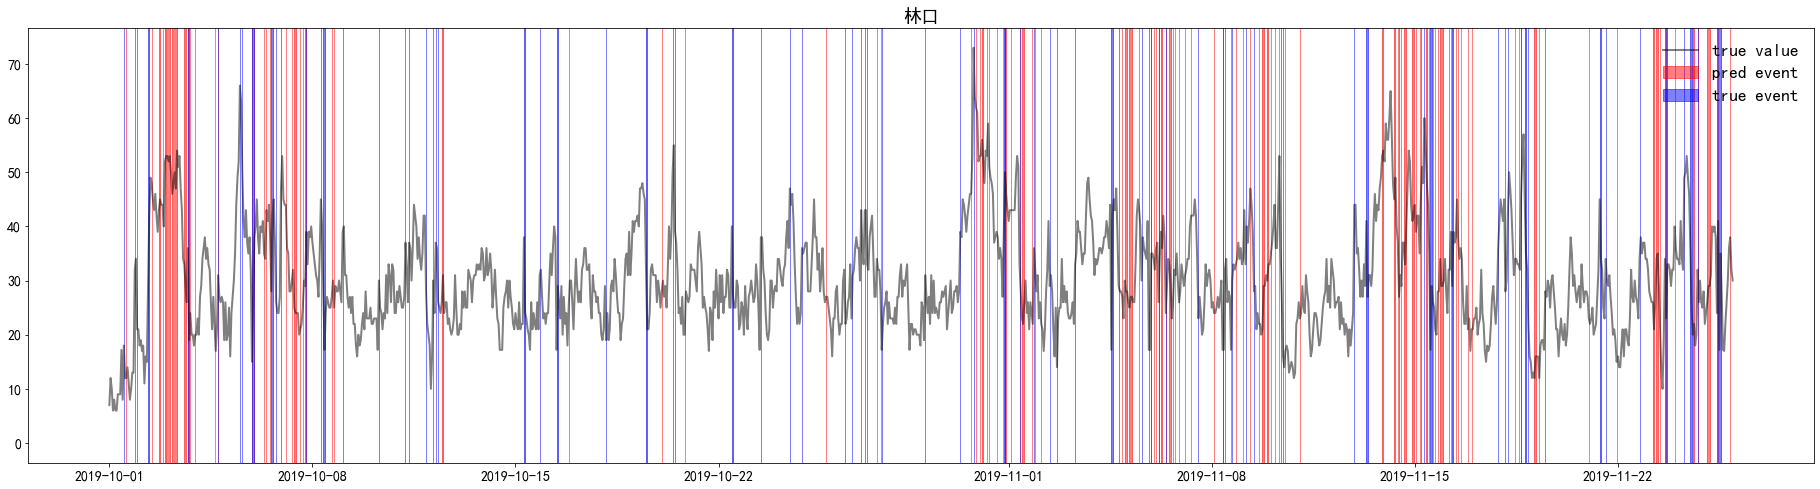

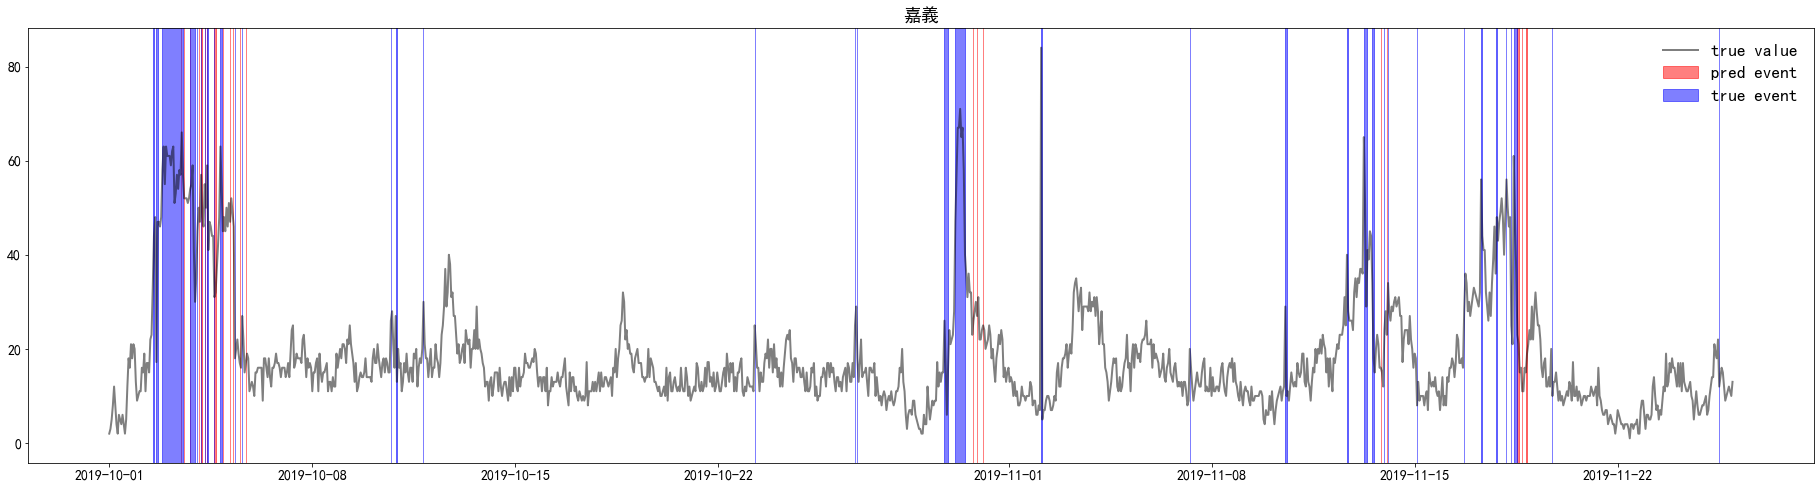

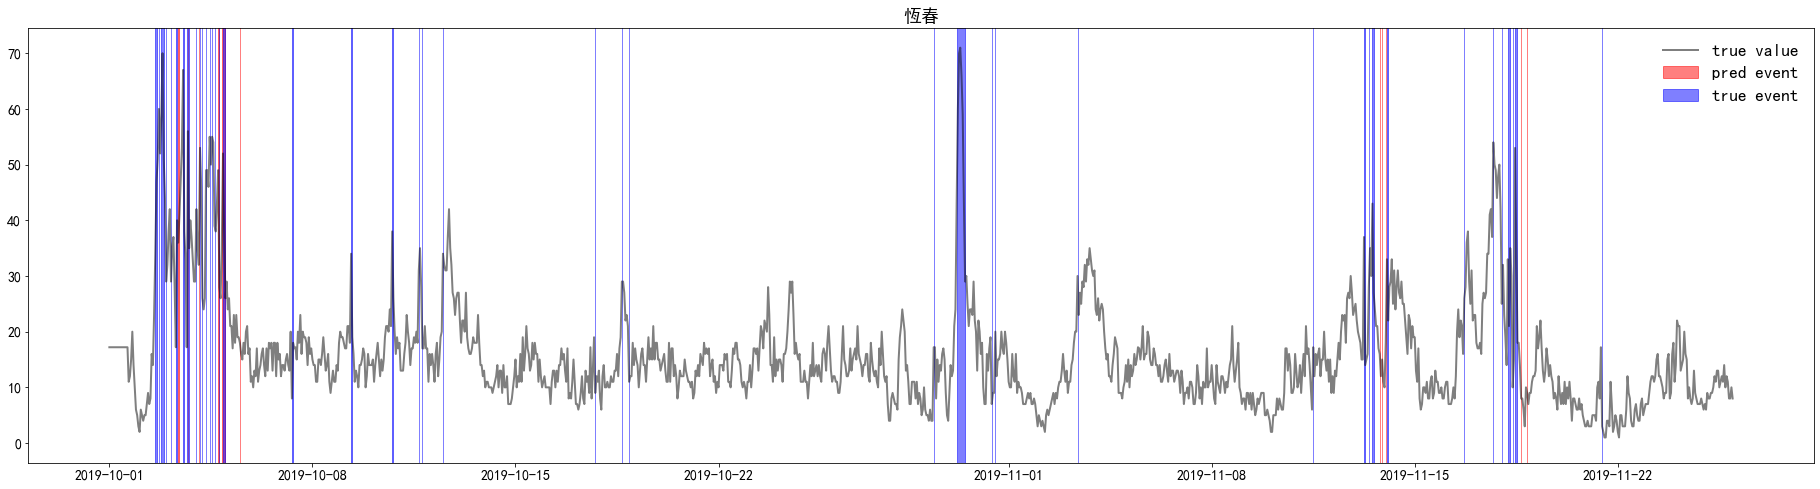

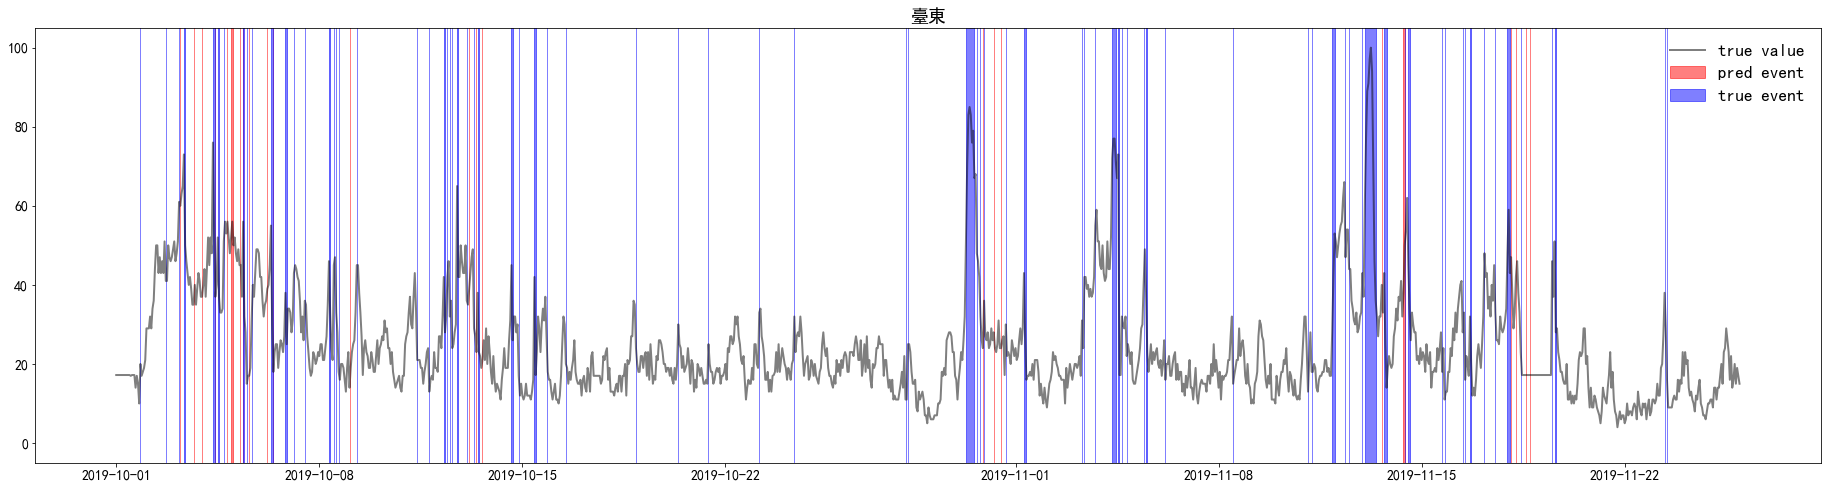

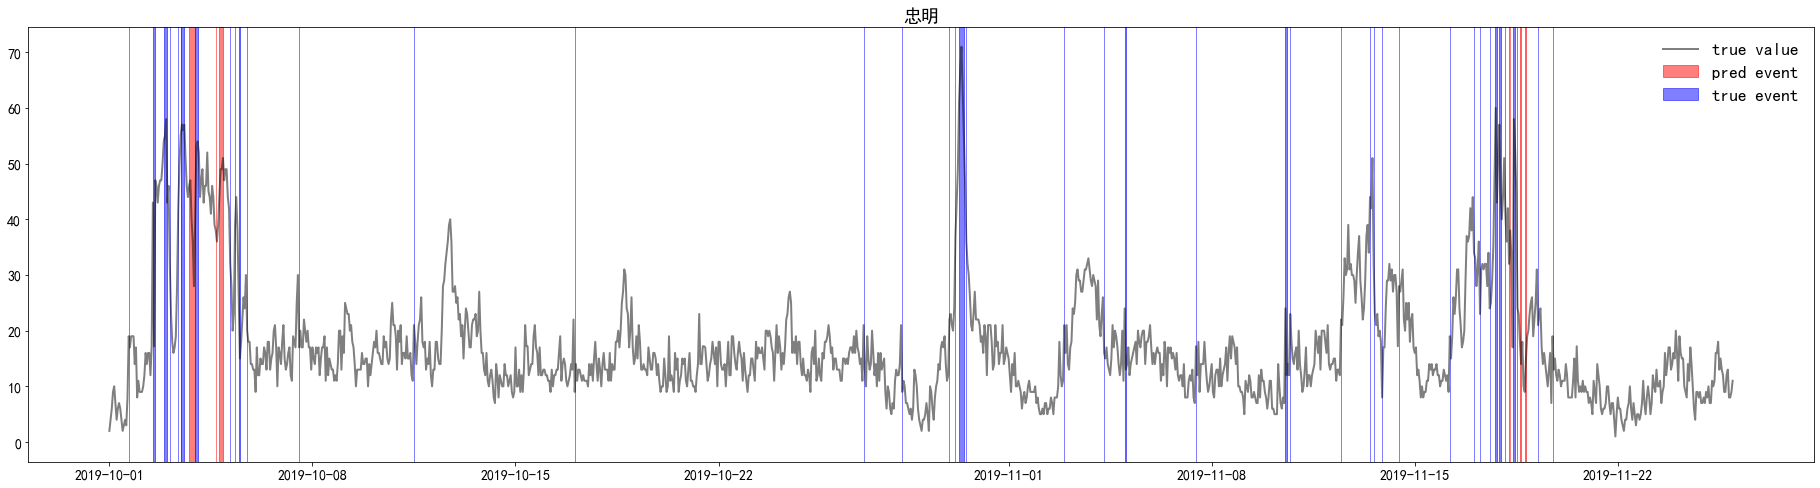

In [23]:
# For classification output
def plot(sitename, no):
    # -------------------------------
    # Load data
    # -------------------------------
    if opt.method == "fudan":
        pred   = np.load(f"{opt.rst_dir}/{no}/{sitename}_class.npy")[:, :, 0]
    else:
        pred   = np.load(f"{opt.rst_dir}/{no}/{sitename}.npy")[:, :, 0]
    true   = np.load(f"{opt.origin_valid_dir}/{sitename}.npy")[:, 7]
    thres  = np.load(f"{opt.thres_valid_dir}/{sitename}.npy") [:, 7] 
    date   = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    mask   = get_mask(opt, true, thres)
#     print(pred.shape, true.shape, thres.shape, date.shape, mask.shape)
    total_size = true.shape[0]
    # -------------------------------
    # Shift data
    # -------------------------------
    pred  = pred[:, shift]
    ## shift [-1, -2, ...]
    true  = true [:total_size+shift+1]
    thres = thres[:total_size+shift+1]
    date  = date [:total_size+shift+1]
    mask  = mask [:total_size+shift+1]
    
    true  = true [-pred.shape[0]:]
    thres = thres[-pred.shape[0]:]
    date  = date [-pred.shape[0]:]
    mask  = mask [-pred.shape[0]:]
#     print(pred.shape, true.shape, thres.shape, date.shape, mask.shape)
    # -------------------------------
    # Zoom data
    # -------------------------------
    st = np.where(date == '2019/10/01 00:00')[0][0]
    ed = st + 24 * 28 * 2
#     st = 0
#     ed = -1
    true  = true  [st:ed]
    thres = thres [st:ed]
    mask  = mask  [st:ed]
    x     = date  [st:ed]
    pred  = pred  [st:ed]
    # -------------------------------
    # Draw data
    # -------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.fill_between(x, 0, max(true), 
                    where=pred>.5, 
                    color='r', 
                    alpha=0.5, 
                    transform=ax.get_xaxis_transform(),
                    label='pred event'
                   )
    ax.fill_between(x, 0, max(true), 
                    where=mask>.5, 
                    color='b', 
                    alpha=0.5, 
                    transform=ax.get_xaxis_transform(),
                    label='true event'
                   )
    ax.plot(x, true,      color='black',  lw=2,  alpha=.5, label='true value')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

no = 146
args = [f"--no={no}"]
opt = parse(args)
with open(f"{opt.cfg_dir}/{opt.no}.json", "r") as fp:
    opt = json.load(fp)
opt = Namespace(**opt)
# opt.use_abs_delta = False
same_seeds(opt.seed)
shift = -1 # -1 ... -target_size

# for sitename in SAMPLE_SITES:
for sitename in ['左營', '復興', '頭份', '竹山', '林口', '嘉義', '恆春', '臺東', '忠明']:
#     print(sitename)
    plot(sitename, f"{no}")
#     break